# Sankey Analysis

We are trying to take a look how customers "journey" from one offer to another. This will demonstrate that post-week is indeed polluted by the next premo-week.

In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

import datetime
import pandas as pd
import numpy as np

from google.cloud import bigquery
import matplotlib.pyplot as plt

# plt.rcParams['axes.grid'] = True
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-super-dev')

def sql2df(sql):
    df = bq.query(sql).result().to_dataframe()
    return df    

In [2]:
sql = '''
    WITH core_table AS (
        SELECT 
            a.*,
            ROW_NUMBER() OVER(PARTITION BY crn ORDER BY campaign_start_date) rn
        FROM (
             SELECT DISTINCT 
                crn, 
                campaign_start_date, 
                offer_type,  
                campaign_length
             FROM `gcp-wow-rwds-ai-mmm-super-dev.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
        ) a
    ), raw_sankey_table AS (
        SELECT 
            a.campaign_start_date,
            a.crn,
            DATE_DIFF(b.campaign_start_date, a.campaign_start_date, day) AS days_lapsed,
            a.campaign_length,
            a.offer_type,
            b.offer_type AS offer_type_next
        FROM 
            core_table a 
            LEFT JOIN core_table b 
                ON a.crn = b.crn AND a.rn = (b.rn - 1)
    ), core_sankey_table AS (
        SELECT 
            campaign_start_date,
            offer_type,
            CASE 
                WHEN days_lapsed <= campaign_length THEN offer_type_next
                ELSE NULL
            END AS offer_type_next,
            COUNT(1) AS n 
        FROM raw_sankey_table 
        GROUP BY 1,2,3
    )
    SELECT  
        a.campaign_start_date, 
        a.offer_type,
        a.offer_type_next,
        a.n, 
        b.total_n,
        a.n / b.total_n AS p
    FROM 
        core_sankey_table a 
        JOIN (
            SELECT campaign_start_date, offer_type, SUM(n) total_n
            FROM core_sankey_table
            GROUP BY 1,2 
        ) b ON a.campaign_start_date = b.campaign_start_date AND a.offer_type = b.offer_type
    ORDER BY 1,2,3;
'''

In [3]:
df = sql2df(sql)
df['offer_type_next'].fillna('None', inplace=True)
df['campaign_start_date'] = df['campaign_start_date'].apply(lambda x: x.strftime('%Y-%m-%d')) 

campaign_start_dates = sorted(list(set(df['campaign_start_date'])))
campaign_start_dates.pop()

'2021-05-24'

In [4]:
df_agg = df.copy()
df_agg['offer_type_next'] = df_agg['offer_type_next'].apply(lambda x: 'Rollover' if x != 'None' else x)
df_agg = df_agg.groupby(['campaign_start_date', 'offer_type_next']).agg({'n': sum}).reset_index()
_df_agg = df_agg.groupby(['campaign_start_date']).agg({'n': sum}).reset_index()
df_agg = df_agg.merge(_df_agg, on='campaign_start_date')
df_agg['p'] = df_agg['n_x'] / df_agg['n_y']
df_agg = df_agg[['campaign_start_date', 'offer_type_next', 'p']]

In [5]:
df_agg_agg = df.copy()
df_agg_agg['offer_type_next'] = df_agg_agg['offer_type_next'].apply(lambda x: 'Rollover' if x != 'None' else x)
df_agg_agg = df_agg_agg.groupby(['offer_type_next']).agg({'n': sum}).reset_index()

### Total rollover vs DNS

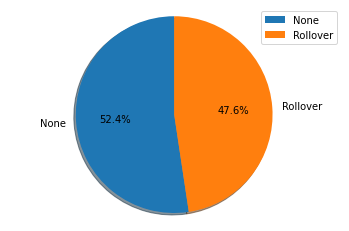

In [6]:
labels = 'None', 'Rollover'
sizes = [df_agg_agg[df_agg_agg['offer_type_next'] == 'None']['n'].values[0], df_agg_agg[df_agg_agg['offer_type_next'] == 'Rollover']['n'].values[0]]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.legend()
plt.show()

### Total rollover vs DNS over time

In [7]:
DESTINATION = ['None', 'Rollover']
n_date = len(campaign_start_dates)
n_destination = len(DESTINATION)
width = 0.66

transfer = np.zeros((n_date, n_destination))
for i in range(n_date):
    for j in range(n_destination):
        try:
            transfer[i, j] = df_agg[df_agg['campaign_start_date']==campaign_start_dates[i]][df_agg['offer_type_next']==DESTINATION[j]]['p'].values[0] * 100
        except:
            pass
bottom = transfer[:,:-1]
bottom = np.append(np.zeros((transfer.shape[0],1)), bottom, axis=1)

fig, ax = plt.subplots(figsize=(18,6))
for i in range(n_destination):
    ax.bar(campaign_start_dates, list(transfer[:,i]), width, bottom=list(bottom[:,i]), label=DESTINATION[i])
ax.legend()
ax.set_xlabel('campaign_start_date')
ax.set_ylabel('% next offer')
plt.xticks(rotation=90)
plt.show()

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


### Total Rollover (by offer) and DNS by time

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


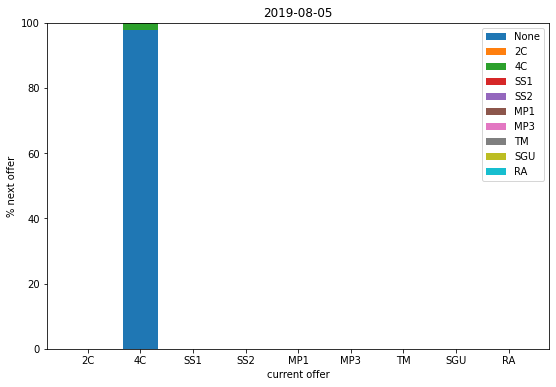

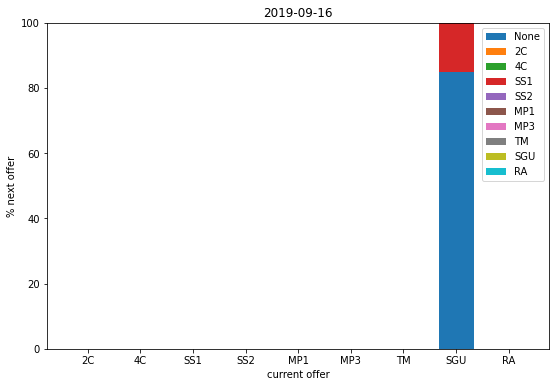

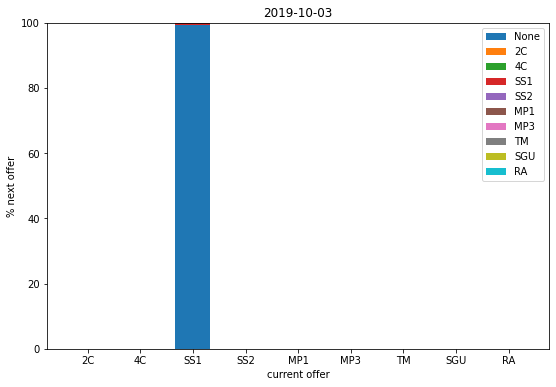

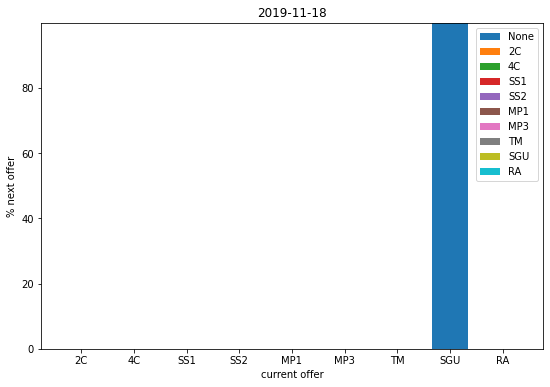

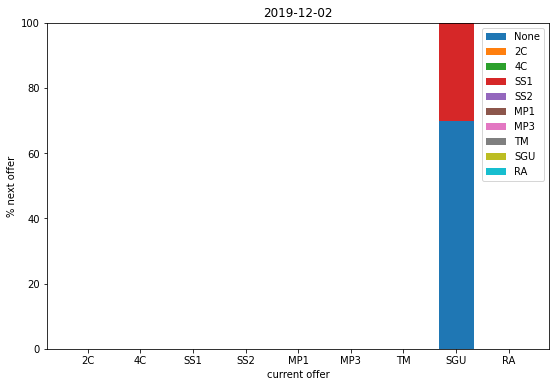

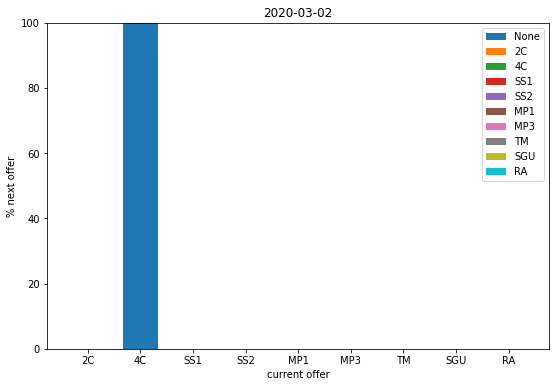

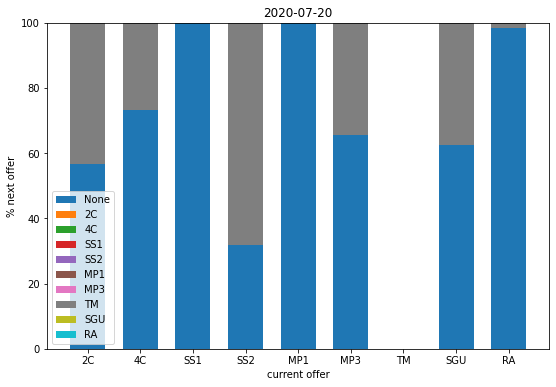

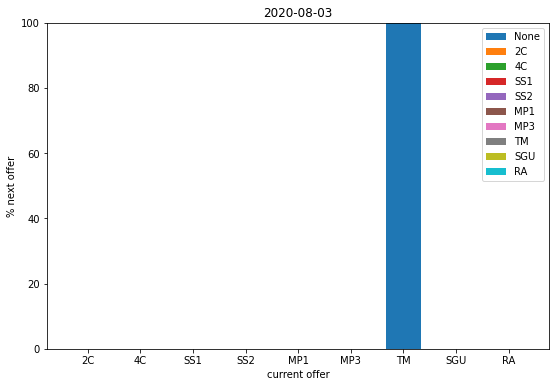

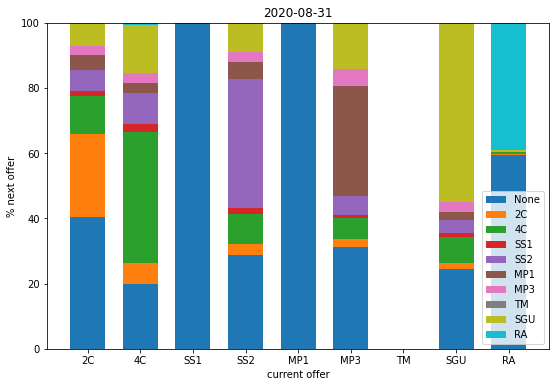

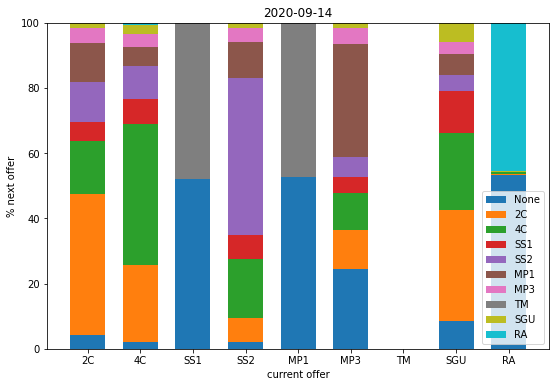

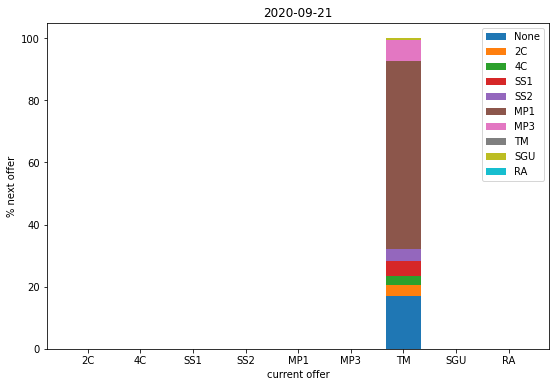

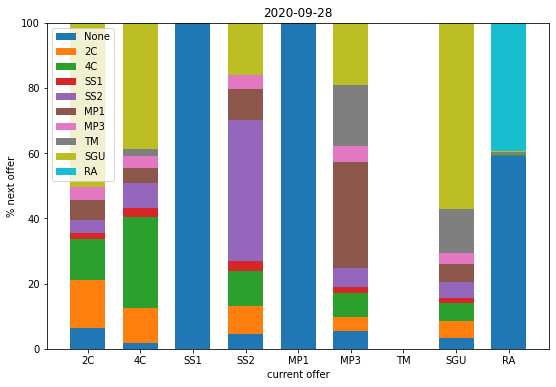

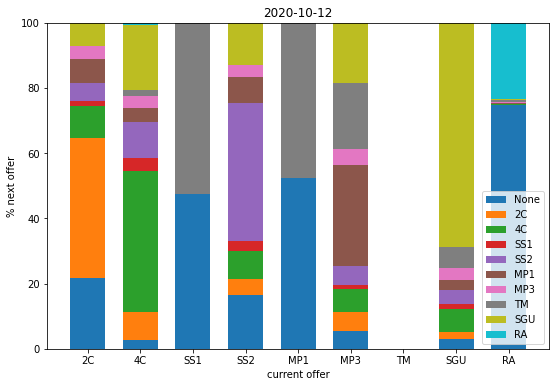

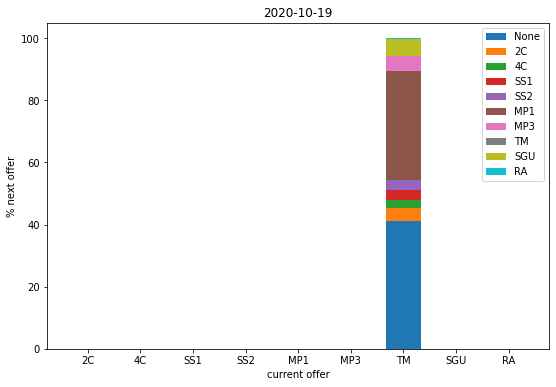

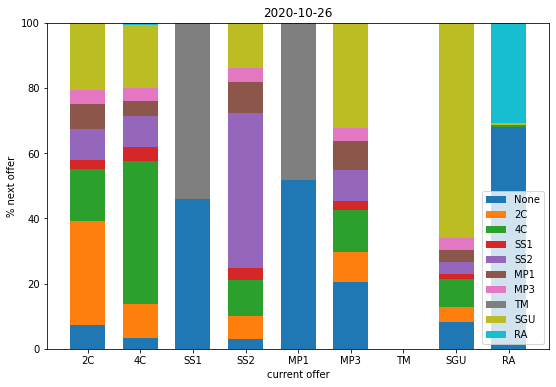

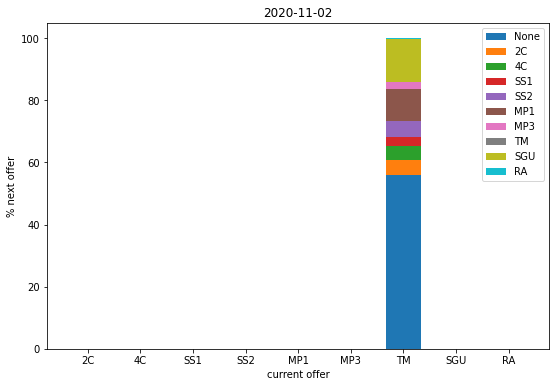

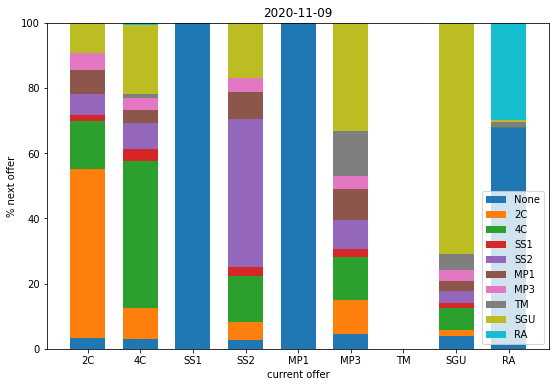

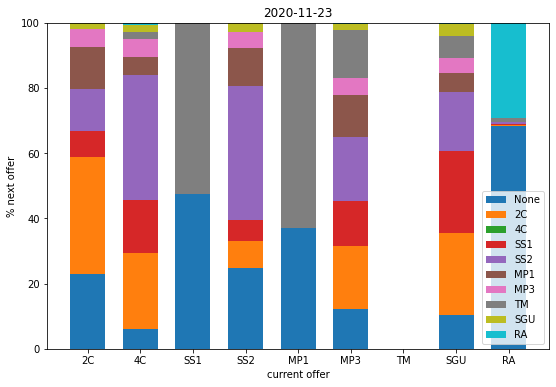

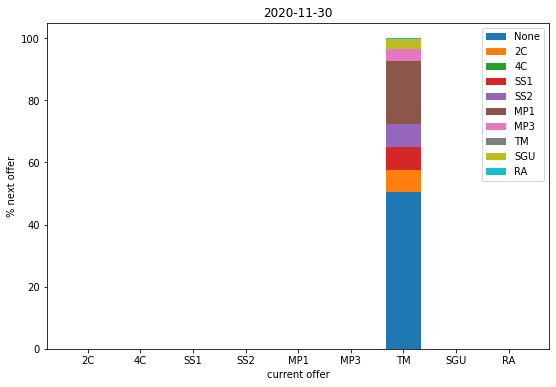

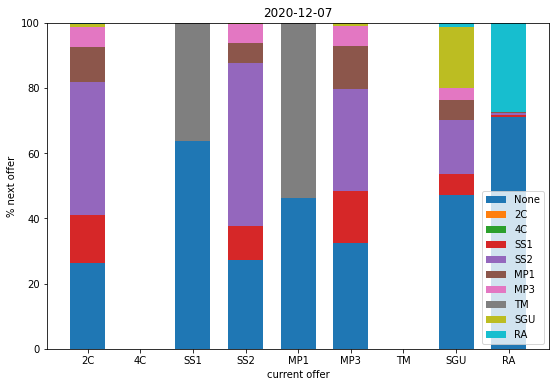

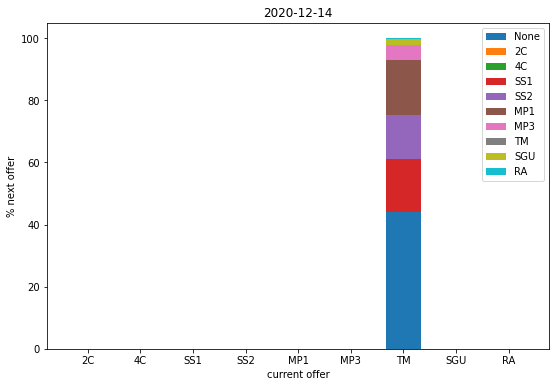

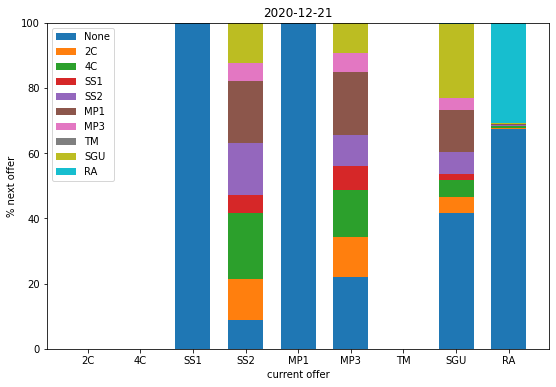

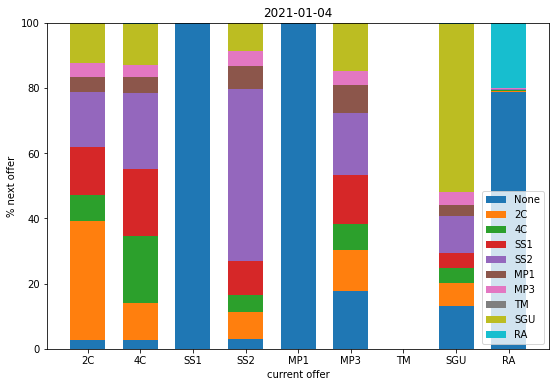

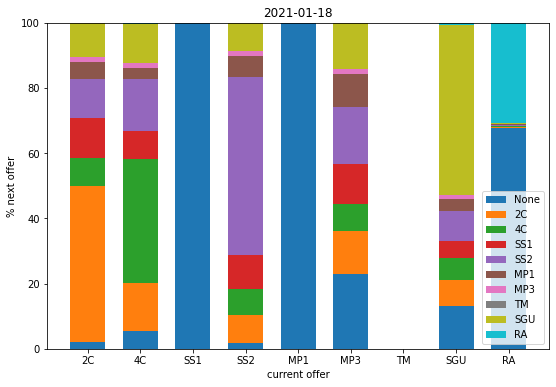

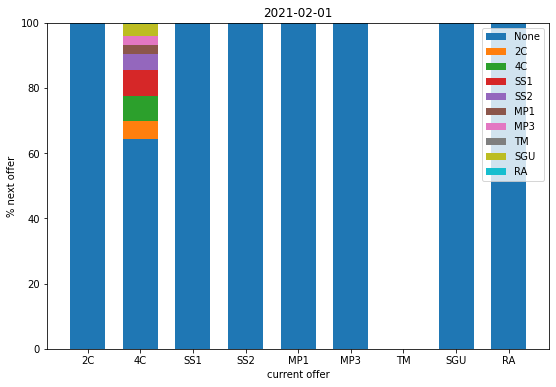

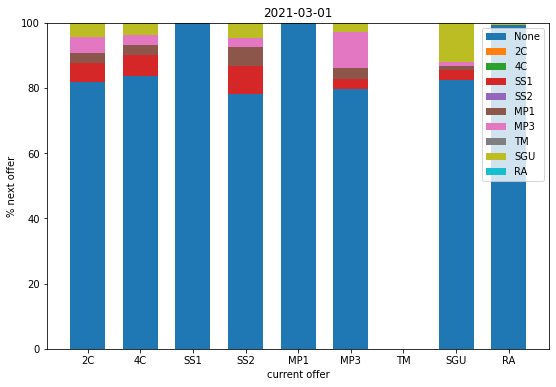

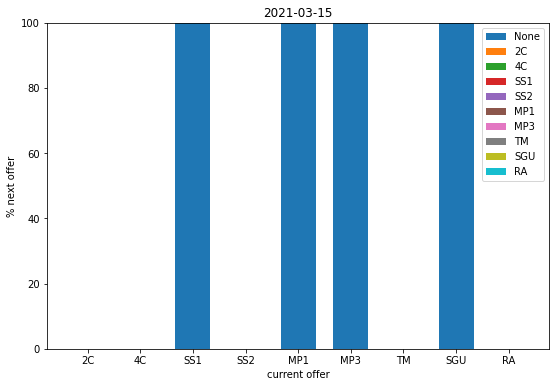

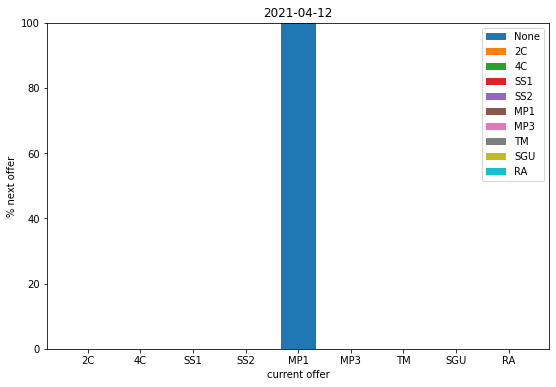

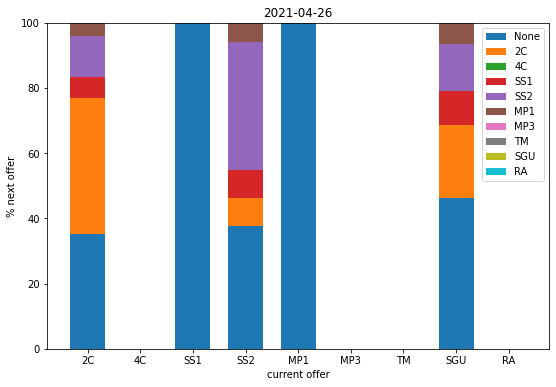

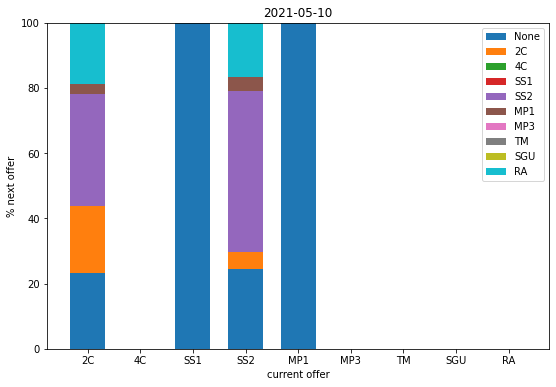

In [8]:
SOURCE = ['2C', '4C', 'SS1', 'SS2', 'MP1', 'MP3', 'TM', 'SGU', 'RA']
DESTINATION = ['None'] + SOURCE
n_source = len(SOURCE)
n_destination = len(DESTINATION)
width = 0.67

for campaign_start_date in campaign_start_dates:
    
    _df = df[df['campaign_start_date'] == campaign_start_date]
    transfer = np.zeros((n_source, n_destination))
    for i in range(n_source):
        for j in range(n_destination):
            try:
                transfer[i, j] = _df[_df['offer_type']==SOURCE[i]][_df['offer_type_next']==DESTINATION[j]]['p'].values[0] * 100
            except:
                pass
    bottom = transfer[:,:-1].cumsum(axis=1) 
    bottom = np.append(np.zeros((9,1)), bottom, axis=1)

    fig, ax = plt.subplots(figsize=(9,6))
    for i in range(n_destination):
        ax.bar(SOURCE, list(transfer[:,i]), width, bottom=list(bottom[:,i]), label=DESTINATION[i])
    ax.legend()
    ax.set_xlabel('current offer')
    ax.set_ylabel('% next offer')
    ax.set_title(campaign_start_date)
    plt.show()
